### Introduction
常用股票技术指标
- 移动平均线（Moving Averages）：显示股票在特定时间段内的平均价格，有助于平滑价格波动，识别趋势。
- 相对强弱指数（RSI）：衡量股票过去一段时间内价格变动的速度和变化，评估股票的超买或超卖状态。
- 移动平均收敛/发散（MACD）：通过计算短期和长期移动平均线之间的差异来识别趋势的强度和方向。

In [50]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition 
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

### Read historical prices

- 读取股票的历史价格数据。
- 选择一个更近的起始日期（2010年）来减少分析的数据量。
- 移除不需要的早期数据。
- 重新索引数据框，以确保数据的整洁性。

In [51]:
ETF_NAME = 'aapl'
ETF_DIRECTORY = './data/Stocks/'

df = pd.read_csv(os.path.join(ETF_DIRECTORY, ETF_NAME.lower() + '.us.txt'), sep=',')

df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2010)].copy()
df.index = range(len(df))
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-01-04,27.341,27.470,27.199,27.406,137045797,0
1,2010-01-05,27.508,27.609,27.310,27.454,167718021,0
2,2010-01-06,27.454,27.563,26.990,27.017,153403690,0
3,2010-01-07,27.108,27.148,26.772,26.968,132861904,0
4,2010-01-08,26.946,27.148,26.774,27.147,124730848,0


### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

In [52]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### Decomposition

- Observed - 原始时间序列数据，即实际的观测值。
- Trend - 时间序列的长期趋势成分，它反映了序列的逐渐上升或下降的趋势。
- Seasonal - 时间序列的季节性成分，它反映了数据中的周期性波动，这种波动具有固定的周期（在这个例子中是年度周期，因为设置了 period=365）。
- Residual - 时间序列的残差成分，它是观测值与趋势和季节性成分之差，通常被视为随机噪声或不可解释的变动。

,Close
Date,
2010-01-04,27.406
2010-01-05,27.454
2010-01-06,27.017
2010-01-07,26.968
2010-01-08,27.147


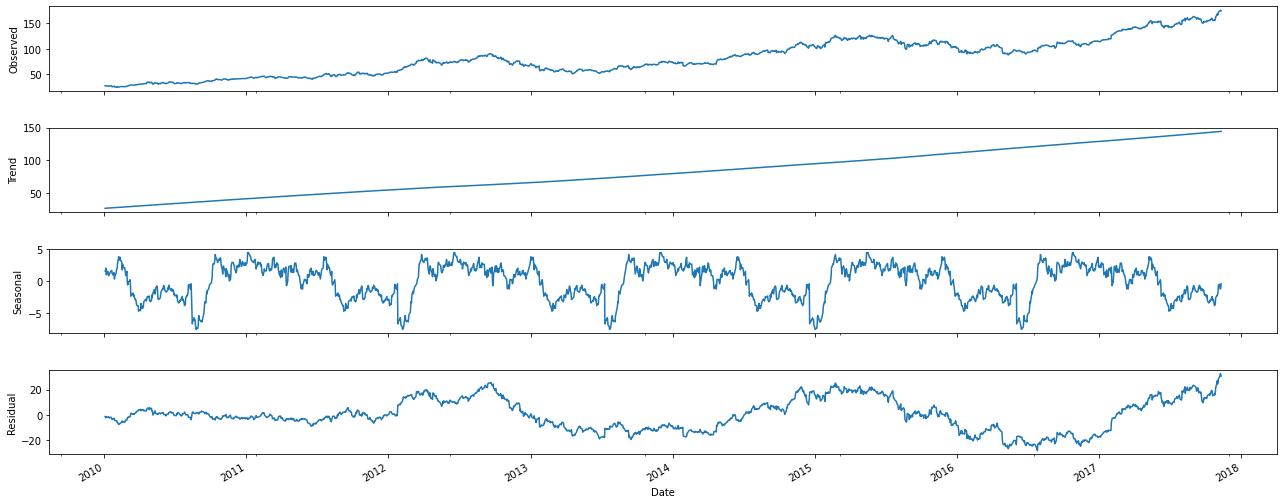

In [53]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')

display(df_close.head())

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.
- **简单移动平均线（Simple Moving Average, SMA）**：
  - $SMA_{5}$：这是5天的简单移动平均线，意味着它计算过去5天内股票收盘价的平均值。如果今天是第6天，那么$SMA_{5}$将是第1天到第5天的收盘价之和除以5。
  - $SMA_{10}$：这是10天的简单移动平均线，计算过去10天的收盘价平均值。
  - $SMA_{15}$：这是15天的简单移动平均线，计算过去15天的收盘价平均值。
  - $SMA_{30}$：这是30天的简单移动平均线，计算过去30天的收盘价平均值。
  
简单移动平均线的一个缺点是它赋予所有价格相同的权重，即使是旧的价格。这意味着，尽管$SMA_{5}$更多地关注最近5天的价格，但它仍然包括了5天前不那么相关的数据。
- **指数移动平均线（Exponential Moving Average, EMA）**：
  - $EMA_{9}$：这是9天的指数移动平均线。与简单移动平均线不同，EMA会给最近的价格更高的权重，这意味着它对价格变动的反应更快。EMA通过计算一个加权平均值来实现这一点，其中最近的价格有更高的权重，而更早的价格权重逐渐减小。
EMA的计算涉及以下步骤：
  1. 首先计算简单移动平均线（通常是第一个EMA周期的SMA）。
  2. 然后计算平滑常数，它决定了最近价格的影响程度。对于EMA，这个常数通常是一个小于1的数字（例如，9天EMA的平滑常数可能是0.2）。
  3. 最后，应用平滑常数来计算EMA，公式如下：
     $$
 EMA_{\text{today}} = (\text{Price}_{\text{today}} - EMA_{\text{yesterday}}) \times \text{Smoothing Constant} + EMA_{\text{yesterday}} 
$$

In [54]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

相对强度指数（Relative Strength Index，简称RSI）是一个动量指标，用于衡量股票或其他资产价格变动的速度和变化，以评估股票是处于超买还是超卖状态。RSI的值范围在0到100之间，通常的阈值为70和30：
- 当RSI值高于70时，股票通常被认为是超买（overbought），这意味着它可能已经上涨得太快，可能会有回调或反转的风险。
- 当RSI值低于30时，股票通常被认为是超卖（oversold），这意味着它可能已经下跌得太快，可能会出现反弹或反转的机会。
以下是RSI的计算步骤：
1. 计算价格上涨日和下跌日的平均收益（平均涨幅和平均跌幅）。
2. 计算RS（Relative Strength），即平均涨幅除以平均跌幅。
3. 使用RS值计算RSI，公式为：RSI = 100 - (100 / (1 + RS))。


In [55]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi


df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

MACD（Moving Average Convergence Divergence，移动平均收敛/发散）是一个流行的趋势跟踪动量指标，它通过两条移动平均线的关系来显示资产价格的趋势和动力。MACD的计算涉及以下步骤：
1. **计算两个不同周期的指数移动平均（EMA）**：
   - 短期EMA：通常使用12期的EMA。
   - 长期EMA：通常使用26期的EMA。
2. **求两个EMA的差值**：
   - MACD线 = 短期EMA - 长期EMA。
3. **计算MACD的信号线**：
   - 信号线通常是MACD线的9期EMA。
4. **计算MACD的直方图（Histogram）**：
   - 直方图 = MACD线 - 信号线。
MACD指标的解释如下：
- **MACD线与信号线的交叉**：当MACD线上穿信号线时，通常被视为买入信号；当MACD线下穿信号线时，通常被视为卖出信号。
- **MACD直方图的峰值和谷值**：直方图的峰值和谷值可以帮助确认趋势的强度和可能的反转点。
以下是MACD的一些应用：
- **趋势识别**：MACD的斜率和方向可以帮助识别当前的趋势是上升、下降还是横盘。
- **动量确认**：MACD线与信号线之间的差距可以表明动量的强度。
- **交易信号**：MACD的交叉点和直方图的变化可以提供交易信号。


In [56]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [57]:
df['Close'] = df['Close'].shift(-1)

### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [58]:
df = df.iloc[33:]  # Because of moving averages and MACD line
df = df[:-1]  # Because of shifting close price

df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [59]:
test_size = 0.15
valid_size = 0.15

test_split_idx = int(df.shape[0] * (1 - test_size))
valid_split_idx = int(df.shape[0] * (1 - (valid_size + test_size)))

train_df = df.loc[:valid_split_idx].copy()
valid_df = df.loc[valid_split_idx + 1:test_split_idx].copy()
test_df = df.loc[test_split_idx + 1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date, y=test_df.Close, name='Test'))
fig.show()

### Drop unnecessary columns

In [60]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df = test_df.drop(drop_cols, 1)

### Split into features and labels

In [61]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test = test_df['Close'].copy()
X_test = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1363 non-null   float64
 1   SMA_5        1363 non-null   float64
 2   SMA_10       1363 non-null   float64
 3   SMA_15       1363 non-null   float64
 4   SMA_30       1363 non-null   float64
 5   RSI          1363 non-null   float64
 6   MACD         1363 non-null   float64
 7   MACD_signal  1363 non-null   float64
dtypes: float64(8)
memory usage: 85.3 KB


### Fine-tune XGBoostRegressor

In [70]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = -0.44305252332532047
Wall time: 5min 25s


In [71]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# model = xgb.XGBRegressor(
#     **{'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 400, 'random_state': 42},
#     objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

from sklearn.svm import SVR
# from sklearn.tree import DecisionTreeRegressor
# 
# # model = SVR(kernel='rbf')
# model = DecisionTreeRegressor(max_depth=32)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f'y_true = {np.array(y_test)[:5]}')
# print(f'y_pred = {y_pred[:5]}')

Wall time: 516 ms


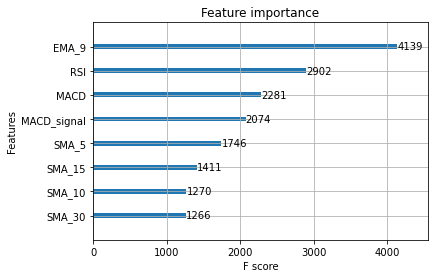

In [72]:
plot_importance(model);

### Calculate and visualize predictions

In [73]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [111.21 111.2  111.18 112.23 110.36]
y_pred = [108.3488  112.68751 112.56374 112.44422 110.8841 ]


In [74]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 596.767333300437


In [75]:
predicted_prices = df.loc[test_split_idx + 1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()